# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [1]:
import matplotlib.pyplot as plt
from math import exp
import scipy.stats as st
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [2]:
df_train = pd.read_csv('CSVs/kc_house_data_train.csv', index_col = 0)

## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

In [4]:
def date_time(df):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['date'] = df['date'].apply(lambda x: x.value)
    
date_time(df_train)

In [5]:
features = list(df_train.columns)
len(features)

21

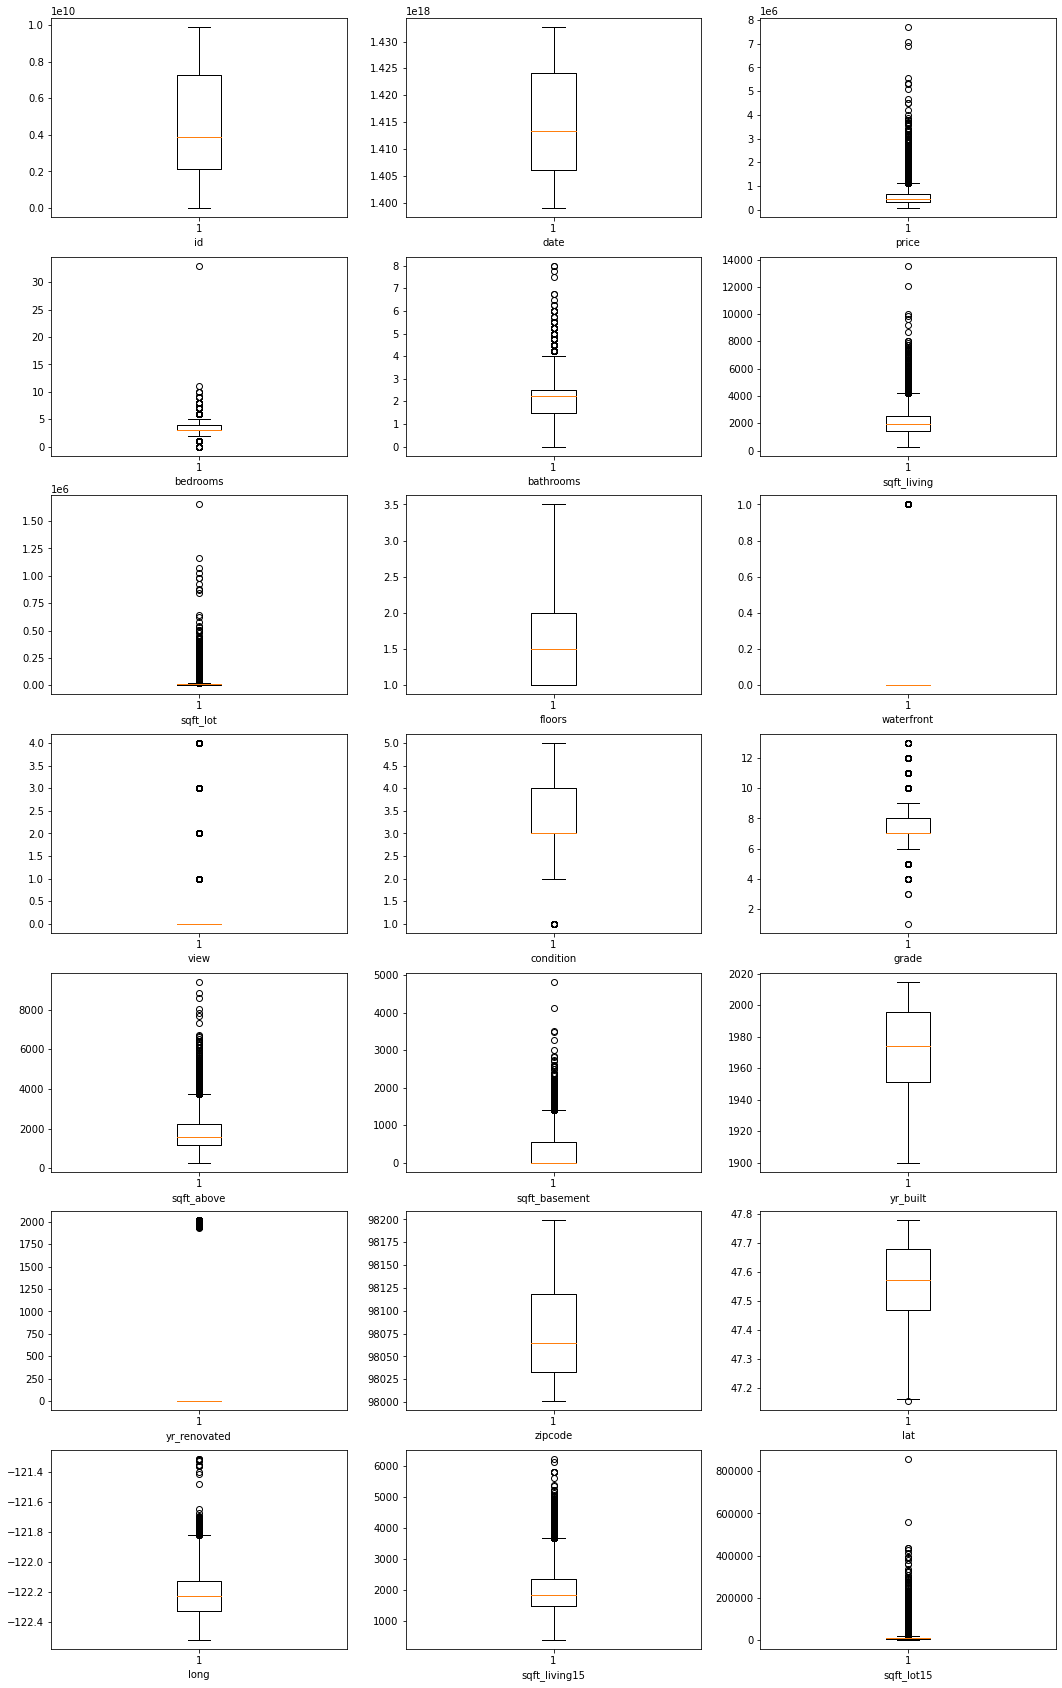

In [6]:
f, axs = plt.subplots(7, 3, sharey=False, figsize = (18,30))
count = 0
while count < 21:
    for i in (0, 1, 2, 3, 4, 5, 6):
        for x in (0, 1, 2):
            axs[i, x].boxplot(df_train.iloc[:, count])
            axs[i, x].set_xlabel(features[count])
            count += 1



## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

In [7]:
bdrm_per_sf = df_train['bedrooms'].mean() / df_train['sqft_living'].mean()

x = df_train['bedrooms']
y = df_train['sqft_living']

condlist = [x > 15, x<= 15]
choicelist = [round(y * bdrm_per_sf, 0), x]

df_train['bedrooms'] = np.select(condlist, choicelist)

## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [8]:
df_train['second_sale'] = [1 if x == True else 0 for x in df_train.duplicated(subset='id', keep='last')]

In [9]:
zips_by_price = df_train.groupby('zipcode').mean()['price'].to_frame()
zips_by_price = zips_by_price.sort_values('price').reset_index().reset_index()
zips_by_price['index'] = zips_by_price['index'] + 1

df_train['zips_by_price'] = df_train['zipcode']
zips_by_mean_price_dict = dict(zip(zips_by_price['zipcode'], zips_by_price['index']))
df_train['zips_by_price'].replace(zips_by_mean_price_dict, inplace = True)

df_train['log_zipbyprice'] = np.log(df_train['zips_by_price'])
df_train['zips_by_price_exp'] = np.exp(0.0198 * df_train['zips_by_price'])

Text(0.5, 0, 'Price and e^(0.0198*Zip Index)')

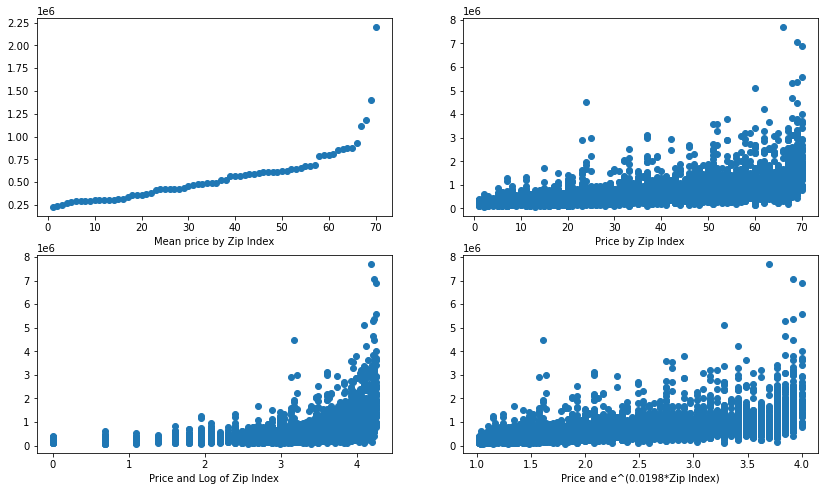

In [10]:
f, axs = plt.subplots(2, 2, sharey=False, figsize = (14,8))

axs[0, 0].scatter(zips_by_price['index'], zips_by_price['price'])
axs[0, 0].set_xlabel('Mean price by Zip Index')

axs[0, 1].scatter(df_train['zips_by_price'], df_train['price'])
axs[0, 1].set_xlabel('Price by Zip Index')

axs[1, 0].scatter(df_train['log_zipbyprice'], df_train['price'])
axs[1, 0].set_xlabel('Price and Log of Zip Index')

axs[1, 1].scatter(df_train['zips_by_price_exp'], df_train['price'])
axs[1, 1].set_xlabel('Price and e^(0.0198*Zip Index)')



In [11]:
#not useful
df_train.drop(columns = 'log_zipbyprice', inplace = True)

In [12]:
df_train['distance_from_space_needle'] = np.sqrt((47.6205 - df_train['lat']) ** 2 + (122.3493 - df_train['long']) ** 2)

In [13]:
df_price = pd.read_csv('CSVs/KC_zips_price.csv')
zips_by_mean_price_dict_ext = dict(zip(df_price['Zip'], df_price['Rank']))
df_train['zips_by_price_ext'] = df_train['zipcode']
df_train['zips_by_price_ext'].replace(zips_by_mean_price_dict_ext, inplace = True)

x = df_train['zips_by_price_ext']
condlist = [x > 50, x <51]
choicelist = [51, x]
df_train['zips_by_price_ext_tidy'] = np.select(condlist, choicelist)

df_train['zips_by_price_ext_tidy_power'] = df_train['zips_by_price_ext_tidy'] ** -.316

In [14]:
#not useful
df_train.drop(columns = 'zips_by_price_ext', inplace = True)

In [15]:
zip_indexing_NICHE = pd.read_csv("CSVs/zip_indexing_NICHE.csv")
zips_by_NICHErank_dict = dict(zip(zip_indexing_NICHE['Zip'], zip_indexing_NICHE['NICHE ranking']))

df_train['zips_by_liv_qual'] = df_train['zipcode']
df_train['zips_by_liv_qual'].replace(zips_by_NICHErank_dict, inplace = True)
df_train['zips_by_liv_qual'].replace({98005: 13, 98022: 51, 26:1}, inplace = True)

df_train['mod_zips_by_liv_qual'] = np.exp(-0.015 * df_train['zips_by_liv_qual'])

In [16]:
df_train['sale_year'] = pd.DatetimeIndex(df_train['date']).year

x = df_train['yr_renovated']
y = df_train['sale_year']
z = df_train['yr_built']
condlist = [x == 0, x != 0]
choicelist = [y-z, y-x]
df_train['years_since_reno'] = np.select(condlist, choicelist)

x = df_train['yr_renovated']
condlist = [x >= 2012, x < 2012]
choicelist = [1, 0]
df_train['recent_reno'] = np.select(condlist, choicelist)

In [17]:
x = df_train['sqft_lot']

condlist = [x >= 10000, x < 10000]
choicelist = [x - np.sqrt(x), x]
df_train['sqft_lot'] = np.select(condlist, choicelist)

In [18]:
#These turned out to not be useful

#df_train['sqft_living_2'] = df_train['sqft_living'] ** 2
#df_train['sqft_living_3'] = df_train['sqft_living'] ** 3 
#df_train['sqft_living_4'] = df_train['sqft_living'] ** 4
#df_train['sqft_living_5'] = df_train['sqft_living'] ** 5
#df_train['sqft_living_6'] = df_train['sqft_living'] ** 6

In [19]:
x = df_train['sqft_living']

condlist = [x >= 6000, x < 6000]
choicelist = [x-x**(0.5), x]
df_train['sqft_living'] = np.select(condlist, choicelist)

In [20]:
df_train['living_compared_to_15'] = (df_train['sqft_living15'] - df_train['sqft_living']) ** 2
df_train['lot_compared_to_15'] = df_train['sqft_lot15'] - df_train['sqft_lot']


In [21]:
df_train['grade_cats'] = df_train['grade']
df_train['grade_cats'].replace({2:1, 3:1, 4:1,11:13,12:13}, inplace = True)


In [22]:
df_train['zip_rank_variance'] = abs(df_train['zips_by_price'] - df_train['zips_by_liv_qual'])

### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [23]:
df_train = df_train.join(pd.get_dummies(df_train['zipcode'], prefix = 'x', drop_first = True))

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

This code, used above:

In [24]:
#def date_time(df):
#    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
#    df['date'] = df['date'].apply(lambda x: x.value)
    
#date_time(df_train)

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

This code, used above:

In [25]:
#df_train['sale_year'] = pd.DatetimeIndex(df_train['date']).year

#x = df_train['yr_renovated']
#y = df_train['sale_year']
#z = df_train['yr_built']
#condlist = [x == 0, x != 0]
#choicelist = [y-z, y-x]
#df_train['years_since_reno'] = np.select(condlist, choicelist)

#x = df_train['yr_renovated']
#condlist = [x >= 2012, x < 2012]
#choicelist = [1, 0]
#df_train['recent_reno'] = np.select(condlist, choicelist)

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

In [26]:
df_train['bdrms_squared'] = df_train['bedrooms'] ** 2

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [27]:
df_train['waterfront_long'] = (df_train['waterfront'] + 125) * (df_train ['long'])

In [28]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,second_sale,zips_by_price,zips_by_price_exp,distance_from_space_needle,zips_by_price_ext_tidy,zips_by_price_ext_tidy_power,zips_by_liv_qual,mod_zips_by_liv_qual,sale_year,years_since_reno,recent_reno,living_compared_to_15,lot_compared_to_15,grade_cats,zip_rank_variance,x_98002,x_98003,x_98004,x_98005,x_98006,x_98007,x_98008,x_98010,x_98011,x_98014,x_98019,x_98022,x_98023,x_98024,x_98027,x_98028,x_98029,x_98030,x_98031,x_98032,x_98033,x_98034,x_98038,x_98039,x_98040,x_98042,x_98045,x_98052,x_98053,x_98055,x_98056,x_98058,x_98059,x_98065,x_98070,x_98072,x_98074,x_98075,x_98077,x_98092,x_98102,x_98103,x_98105,x_98106,x_98107,x_98108,x_98109,x_98112,x_98115,x_98116,x_98117,x_98118,x_98119,x_98122,x_98125,x_98126,x_98133,x_98136,x_98144,x_98146,x_98148,x_98155,x_98166,x_98168,x_98177,x_98178,x_98188,x_98198,x_98199,bdrms_squared,waterfront_long
0,2591820310,1412553600000000000,365000.0,4.0,2.25,2070.0,8893.000000,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,0,18,1.428179,244.511368,51,0.288674,48,0.486752,2014,28,0,102400.0,-1193.000000,8,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.0,-15270.250
1,7974200820,1408579200000000000,865000.0,5.0,3.00,2900.0,6730.000000,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,0,47,2.536030,244.634307,18,0.401175,16,0.786628,2014,37,0,280900.0,-447.000000,8,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25.0,-15285.625
2,7701450110,1408060800000000000,1038000.0,4.0,2.50,3770.0,10788.630464,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,0,62,3.413028,244.478306,6,0.567681,11,0.847894,2014,17,0,3600.0,-1103.630464,13,51,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.0,-15266.125
3,9522300010,1427760000000000000,1490000.0,3.0,3.50,4560.0,14487.136441,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,0,37,2.080483,244.577313,47,0.296222,27,0.666977,2015,25,0,260100.0,-261.136441,13,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0,-15278.500
4,9510861140,1405296000000000000,711000.0,3.0,2.50,2550.0,5376.000000,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,0,53,2.855937,244.432304,20,0.388038,3,0.955997,2014,10,0,90000.0,-1326.000000,9,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0,-15260.375


### <ins>Statistical Tests</ins>

### 4.6) Statistical Testing for Presentation.

In [29]:
recent_renos = df_train[df_train['recent_reno'] == 1]['price']
no_recent_renos = df_train[df_train['recent_reno'] == 0]['price']
st.ttest_ind(recent_renos, no_recent_renos)

Ttest_indResult(statistic=3.0341099347233653, pvalue=0.0024160473816763174)

In [30]:
view_zero = df_train[df_train['view'] == 0]
view_one = df_train[df_train['view'] == 1]
view_two = df_train[df_train['view'] == 2]
view_three = df_train[df_train['view'] == 3]
view_four = df_train[df_train['view'] == 4]


view_zero_price = view_zero['price']
view_one_price = view_one['price']
view_two_price = view_two['price']
view_three_price = view_three['price']
view_four_price = view_four['price']

st.f_oneway(view_zero_price, view_one_price, view_two_price, view_three_price, view_four_price)

F_onewayResult(statistic=876.7689357683041, pvalue=0.0)

In [31]:
df_train['long_by_sf'] = df_train['long'] * df_train['sqft_living']

from statsmodels.formula.api import ols

ols(formula='price~long_by_sf', data=df_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                 1.692e+04
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:42:55   Log-Likelihood:            -2.4047e+05
No. Observations:               17290   AIC:                         4.809e+05
Df Residuals:                   17288   BIC:                         4.810e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.466e+04   5002.245    -10.928      0.000   -6.45e+04   -4.49e+04
long_by_sf    -2.3412      0.018   -130.086      0.000      -2.376      -2.306
==============================================================================
Omnibus:                    12436.751   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           521317.620
Skew:                           2.986   Prob(JB):                         0.00
Kurtosis:                      29.229   Cond. No.                     6.89e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
#Not useful for overall model
df_train.drop(columns = 'long_by_sf', inplace = True)

## Step 5: Model Evaluation



## 5.1)  Fit an initial model and check the errors to see if the model assumptions are being met. If need be, go back to steps 3 and 4 to improve your mdoel. 

In [33]:
features = list(df_train.columns)
features.remove('price')

features

['id',
 'date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'second_sale',
 'zips_by_price',
 'zips_by_price_exp',
 'distance_from_space_needle',
 'zips_by_price_ext_tidy',
 'zips_by_price_ext_tidy_power',
 'zips_by_liv_qual',
 'mod_zips_by_liv_qual',
 'sale_year',
 'years_since_reno',
 'recent_reno',
 'living_compared_to_15',
 'lot_compared_to_15',
 'grade_cats',
 'zip_rank_variance',
 'x_98002',
 'x_98003',
 'x_98004',
 'x_98005',
 'x_98006',
 'x_98007',
 'x_98008',
 'x_98010',
 'x_98011',
 'x_98014',
 'x_98019',
 'x_98022',
 'x_98023',
 'x_98024',
 'x_98027',
 'x_98028',
 'x_98029',
 'x_98030',
 'x_98031',
 'x_98032',
 'x_98033',
 'x_98034',
 'x_98038',
 'x_98039',
 'x_98040',
 'x_98042',
 'x_98045',
 'x_98052',
 'x_98053',
 'x_98055',
 'x_98056',
 'x_98058',
 'x_98059',
 'x_98065',
 'x_98

In [34]:
df_features = df_train[features]
target = df_train['price']
y_given = target

from sklearn.linear_model import LinearRegression

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(df_features, target)

#access output

y_pred = lm.predict(df_features)

given_mae = metrics.mean_absolute_error(y_given, y_pred)
given_mse = metrics.mean_squared_error(y_given, y_pred)
given_rmse = np.sqrt(metrics.mean_squared_error(y_given, y_pred))

print ("R^2 Score:", lm.score(df_features, target))
print('Mean Absolute Error:', given_mae )
print('Mean Squared Error:',  given_mse)
print('Root Mean Squared Error:' , given_rmse)

R^2 Score: 0.7437655598527513
Mean Absolute Error: 114754.351884944
Mean Squared Error: 35708575174.26556
Root Mean Squared Error: 188967.1272318695


### 5.2) Perform a train-test split of the data.

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=1,test_size=0.25)

### 5.3) Fit the model to the training data.

In [36]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

### 5.4) Use the model to predict on the training set and the test set.

In [37]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

### 5.5) Evaluate the training and test predictions using RMSE.

In [38]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))

train_test_diff = round(100*((-train_rmse+test_rmse)/(train_rmse)),2)

In [39]:
print('Training Root Mean Squared Error: $', f"{round(train_rmse,2):,}")
print('Testing Root Mean Squared Error: $' , f"{round(test_rmse,2):,}")
print(train_test_diff, '%')

Training Root Mean Squared Error: $ 189,042.98
Testing Root Mean Squared Error: $ 180,652.13
-4.44 %


### 5.6) Determine if your model is overfit.

In [40]:
if train_test_diff > 10:
    print('The model is likely overfit.')
elif train_test_diff > -10:
    print('The model is fitting well.')
else:
    print("Well that's weird. Did you do your split correctly?")

The model is fitting well.


## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models. You will have to repeat steps 5.3 through 5.6 to determine how your new model is performing. 

In [41]:
corr_features = list(df_train.corr()['price'].abs().sort_values(ascending = False).to_frame().transpose().columns)
corr_features.remove('price')
df_features = df_train[corr_features[:70]]

In [42]:
from sklearn.preprocessing import PolynomialFeatures

poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(df_poly2, target, random_state=1,test_size=0.25)

In [43]:
lm_poly = LinearRegression()
lm_poly = lm_poly.fit(X_train_poly, y_train)

y_pred_train_poly = lm_poly.predict(X_train_poly)
y_pred_test_poly = lm_poly.predict(X_test_poly)

train_rmse_poly = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_poly))
test_rmse_poly = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_poly))

train_test_diff_poly = round(100*((-train_rmse_poly+test_rmse_poly)/(train_rmse_poly)),2)

In [44]:
print('Training Root Mean Squared Error: $', f"{round(train_rmse_poly,2):,}")
print('Testing Root Mean Squared Error: $' , f"{round(test_rmse_poly,2):,}")
print(train_test_diff_poly, '%')

Training Root Mean Squared Error: $ 96,475.44
Testing Root Mean Squared Error: $ 161,836.7
67.75 %


In [45]:
if train_test_diff_poly > 10:
    print('The model is likely overfit.')
elif train_test_diff_poly > -10:
    print('The model is fitting well.')
else:
    print("Well that's weird. Did you do your split correctly?")

The model is likely overfit.


### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [46]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

selector = SelectKBest(f_regression, k=140)
selector.fit(X_train_poly, y_train)

selector.get_support()

array([ True,  True,  True, ..., False, False, False])

In [47]:
selected_columns = X_train_poly.columns[selector.get_support()]
removed_columns = X_train_poly.columns[~selector.get_support()]
X_train_kBest = X_train_poly[selected_columns]
X_test_kBest = X_test_poly[selected_columns]

In [48]:
list(selected_columns)

['sqft_living',
 'grade_cats',
 'grade',
 'sqft_above',
 'zips_by_price_exp',
 'sqft_living15',
 'zips_by_price_ext_tidy_power',
 'zips_by_price',
 'zips_by_price_ext_tidy',
 'bathrooms',
 'sqft_living^2',
 'sqft_living grade_cats',
 'sqft_living grade',
 'sqft_living sqft_above',
 'sqft_living zips_by_price_exp',
 'sqft_living sqft_living15',
 'sqft_living zips_by_price_ext_tidy_power',
 'sqft_living zips_by_price',
 'sqft_living bathrooms',
 'sqft_living mod_zips_by_liv_qual',
 'sqft_living view',
 'sqft_living bedrooms',
 'sqft_living bdrms_squared',
 'sqft_living lat',
 'sqft_living floors',
 'sqft_living waterfront_long',
 'sqft_living zip_rank_variance',
 'sqft_living yr_built',
 'sqft_living zipcode',
 'sqft_living condition',
 'grade_cats^2',
 'grade_cats grade',
 'grade_cats sqft_above',
 'grade_cats zips_by_price_exp',
 'grade_cats sqft_living15',
 'grade_cats zips_by_price_ext_tidy_power',
 'grade_cats zips_by_price',
 'grade_cats bathrooms',
 'grade_cats mod_zips_by_liv_qua

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [49]:
lm_kBest = LinearRegression()

lm_kBest.fit(X_train_kBest, y_train)

y_pred_train_kBest = lm_kBest.predict(X_train_kBest)
y_pred_test_kBest = lm_kBest.predict(X_test_kBest)

train_rmse_kBest = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_kBest))
test_rmse_kBest = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_kBest))

train_test_diff_kBest = round(100*((-train_rmse_kBest+test_rmse_kBest)/(train_rmse_kBest)),2)

print('Training Root Mean Squared Error: $', f"{round(train_rmse_kBest,2):,}")
print('Testing Root Mean Squared Error: $' , f"{round(test_rmse_kBest,2):,}")
print(train_test_diff_kBest, '%')

Training Root Mean Squared Error: $ 129,705.74
Testing Root Mean Squared Error: $ 126,715.09
-2.31 %


In [50]:
#

In [51]:
if train_test_diff_kBest > 10:
    print('The model is likely overfit.')
elif train_test_diff_kBest > -10:
    print('The model is fitting well.')
else:
    print("Well that's weird. Did you do your split correctly?")

The model is fitting well.


## Step 7: Compare the RMSE of your different models that use different features and determine the best model overall.

In [52]:
residuals = y_test - y_pred_test_kBest
top_misses = residuals.abs().sort_values(ascending = False).index[:10]

df_poly2.loc[top_misses]

,sqft_living,grade_cats,grade,sqft_above,zips_by_price_exp,sqft_living15,zips_by_price_ext_tidy_power,zips_by_price,zips_by_price_ext_tidy,bathrooms,mod_zips_by_liv_qual,zips_by_liv_qual,living_compared_to_15,view,sqft_basement,bedrooms,bdrms_squared,lat,waterfront,x_98004,floors,x_98039,x_98040,x_98112,waterfront_long,x_98006,yr_renovated,x_98023,years_since_reno,x_98033,x_98042,x_98168,x_98075,x_98105,sqft_lot,zip_rank_variance,x_98119,x_98199,sqft_lot15,x_98002,x_98003,x_98038,x_98058,x_98106,x_98031,x_98102,x_98198,x_98030,x_98092,x_98055,x_98178,x_98022,x_98005,x_98133,x_98109,x_98032,x_98074,x_98146,yr_built,x_98118,x_98188,x_98053,zipcode,lot_compared_to_15,x_98052,x_98108,x_98155,x_98056,x_98126,condition,sqft_living^2,sqft_living grade_cats,sqft_living grade,sqft_living sqft_above,sqft_living zips_by_price_exp,sqft_living sqft_living15,sqft_living zips_by_price_ext_tidy_power,sqft_living zips_by_price,sqft_living zips_by_price_ext_tidy,sqft_living bathrooms,sqft_living mod_zips_by_liv_qual,sqft_living zips_by_liv_qual,sqft_living living_compared_to_15,sqft_living view,sqft_living sqft_basement,sqft_living bedrooms,sqft_living bdrms_squared,sqft_living lat,sqft_living waterfront,sqft_living x_98004,sqft_living floors,sqft_living x_98039,sqft_living x_98040,sqft_living x_98112,sqft_living waterfront_long,sqft_living x_98006,sqft_living yr_renovated,sqft_living x_98023,sqft_living years_since_reno,sqft_living x_98033,sqft_living x_98042,sqft_living x_98168,sqft_living x_98075,sqft_living x_98105,sqft_living sqft_lot,sqft_living zip_rank_variance,sqft_living x_98119,sqft_living x_98199,sqft_living sqft_lot15,sqft_living x_98002,sqft_living x_98003,sqft_living x_98038,sqft_living x_98058,sqft_living x_98106,sqft_living x_98031,sqft_living x_98102,sqft_living x_98198,sqft_living x_98030,sqft_living x_98092,sqft_living x_98055,sqft_living x_98178,sqft_living x_98022,sqft_living x_98005,sqft_living x_98133,sqft_living x_98109,sqft_living x_98032,sqft_living x_98074,sqft_living x_98146,sqft_living yr_built,sqft_living x_98118,sqft_living x_98188,sqft_living x_98053,sqft_living zipcode,sqft_living lot_compared_to_15,sqft_living x_98052,sqft_living x_98108,sqft_living x_98155,sqft_living x_98056,sqft_living x_98126,sqft_living condition,grade_cats^2,grade_cats grade,grade_cats sqft_above,grade_cats zips_by_price_exp,grade_cats sqft_living15,grade_cats zips_by_price_ext_tidy_power,grade_cats zips_by_price,grade_cats zips_by_price_ext_tidy,grade_cats bathrooms,grade_cats mod_zips_by_liv_qual,...,x_98133 x_98074,x_98133 x_98146,x_98133 yr_built,x_98133 x_98118,x_98133 x_98188,x_98133 x_98053,x_98133 zipcode,x_98133 lot_compared_to_15,x_98133 x_98052,x_98133 x_98108,x_98133 x_98155,x_98133 x_98056,x_98133 x_98126,x_98133 condition,x_98109^2,x_98109 x_98032,x_98109 x_98074,x_98109 x_98146,x_98109 yr_built,x_98109 x_98118,x_98109 x_98188,x_98109 x_98053,x_98109 zipcode,x_98109 lot_compared_to_15,x_98109 x_98052,x_98109 x_98108,x_98109 x_98155,x_98109 x_98056,x_98109 x_98126,x_98109 condition,x_98032^2,x_98032 x_98074,x_98032 x_98146,x_98032 yr_built,x_98032 x_98118,x_98032 x_98188,x_98032 x_98053,x_98032 zipcode,x_98032 lot_compared_to_15,x_98032 x_98052,x_98032 x_98108,x_98032 x_98155,x_98032 x_98056,x_98032 x_98126,x_98032 condition,x_98074^2,x_98074 x_98146,x_98074 yr_built,x_98074 x_98118,x_98074 x_98188,x_98074 x_98053,x_98074 zipcode,x_98074 lot_compared_to_15,x_98074 x_98052,x_98074 x_98108,x_98074 x_98155,x_98074 x_98056,x_98074 x_98126,x_98074 condition,x_98146^2,x_98146 yr_built,x_98146 x_98118,x_98146 x_98188,x_98146 x_98053,x_98146 zipcode,x_98146 lot_compared_to_15,x_98146 x_98052,x_98146 x_98108,x_98146 x_98155,x_98146 x_98056,x_98146 x_98126,x_98146 condition,yr_built^2,yr_built x_98118,yr_built x_98188,yr_built x_98053,yr_built zipcode,yr_built lot_compared_to_15,yr_built x_98052,yr_built x_98108,yr_built x_98155,yr_built x_98056,yr_built x_98126,yr_built condition,x_98118^2,x_98118 x_98188,x_98118 x_98053,x_98118 zipc

In [53]:
df_poly2[selected_columns].loc[top_misses]

,sqft_living,grade_cats,grade,sqft_above,zips_by_price_exp,sqft_living15,zips_by_price_ext_tidy_power,zips_by_price,zips_by_price_ext_tidy,bathrooms,sqft_living^2,sqft_living grade_cats,sqft_living grade,sqft_living sqft_above,sqft_living zips_by_price_exp,sqft_living sqft_living15,sqft_living zips_by_price_ext_tidy_power,sqft_living zips_by_price,sqft_living bathrooms,sqft_living mod_zips_by_liv_qual,sqft_living view,sqft_living bedrooms,sqft_living bdrms_squared,sqft_living lat,sqft_living floors,sqft_living waterfront_long,sqft_living zip_rank_variance,sqft_living yr_built,sqft_living zipcode,sqft_living condition,grade_cats^2,grade_cats grade,grade_cats sqft_above,grade_cats zips_by_price_exp,grade_cats sqft_living15,grade_cats zips_by_price_ext_tidy_power,grade_cats zips_by_price,grade_cats bathrooms,grade_cats mod_zips_by_liv_qual,grade_cats bedrooms,grade_cats lat,grade_cats waterfront_long,grade_cats yr_built,grade_cats zipcode,grade_cats condition,grade^2,grade sqft_above,grade zips_by_price_exp,grade sqft_living15,grade zips_by_price_ext_tidy_power,grade zips_by_price,grade bathrooms,grade mod_zips_by_liv_qual,grade bedrooms,grade lat,grade waterfront_long,grade yr_built,grade zipcode,sqft_above^2,sqft_above zips_by_price_exp,sqft_above sqft_living15,sqft_above zips_by_price_ext_tidy_power,sqft_above zips_by_price,sqft_above bathrooms,sqft_above mod_zips_by_liv_qual,sqft_above view,sqft_above sqft_basement,sqft_above bedrooms,sqft_above bdrms_squared,sqft_above lat,sqft_above floors,sqft_above waterfront_long,sqft_above yr_built,sqft_above zipcode,sqft_above condition,zips_by_price_exp^2,zips_by_price_exp sqft_living15,zips_by_price_exp zips_by_price_ext_tidy_power,zips_by_price_exp zips_by_price,zips_by_price_exp bathrooms,zips_by_price_exp mod_zips_by_liv_qual,zips_by_price_exp bedrooms,zips_by_price_exp bdrms_squared,zips_by_price_exp lat,zips_by_price_exp floors,zips_by_price_exp waterfront_long,zips_by_price_exp yr_built,zips_by_price_exp zipcode,zips_by_price_exp condition,sqft_living15^2,sqft_living15 zips_by_price_ext_tidy_power,sqft_living15 zips_by_price,sqft_living15 bathrooms,sqft_living15 mod_zips_by_liv_qual,sqft_living15 bedrooms,sqft_living15 bdrms_squared,sqft_living15 lat,sqft_living15 floors,sqft_living15 waterfront_long,sqft_living15 yr_built,sqft_living15 zipcode,sqft_living15 condition,zips_by_price_ext_tidy_power^2,zips_by_price_ext_tidy_power zips_by_price,zips_by_price_ext_tidy_power zips_by_price_ext_tidy,zips_by_price_ext_tidy_power bathrooms,zips_by_price_ext_tidy_power mod_zips_by_liv_qual,zips_by_price_ext_tidy_power living_compared_to_15,zips_by_price_ext_tidy_power bedrooms,zips_by_price_ext_tidy_power bdrms_squared,zips_by_price_ext_tidy_power lat,zips_by_price_ext_tidy_power floors,zips_by_price_ext_tidy_power waterfront_long,zips_by_price_ext_tidy_power yr_built,zips_by_price_ext_tidy_power zipcode,zips_by_price^2,zips_by_price bathrooms,zips_by_price mod_zips_by_liv_qual,zips_by_price bedrooms,zips_by_price bdrms_squared,zips_by_price lat,zips_by_price floors,zips_by_price waterfront_long,zips_by_price zip_rank_variance,zips_by_price yr_built,zips_by_price zipcode,zips_by_price condition,zips_by_price_ext_tidy lat,zips_by_price_ext_tidy waterfront_long,zips_by_price_ext_tidy yr_built,zips_by_price_ext_tidy zipcode,bathrooms^2,bathrooms mod_zips_by_liv_qual,bathrooms bedrooms,bathrooms lat,bathrooms waterfront_long,bathrooms yr_built,bathrooms zipcode,bathrooms condition,mod_zips_by_liv_qual bedrooms
5124,5040.000000,10.0,10.0,2870.0,3.413028,4050.0,0.567681,62.0,6.0,4.00,2.540160e+07,50400.000000,50400.000000,1.446480e+07,17201.663291,2.041200e+07,2861.111226,312480.000000,20160.000000,4273.384269,0.0,20160.00000,80640.00000,239753.304000,5040.000000,-7.697844e+07,257040.000000,9.959040e+06,4.939502e+08,25200.000000,100.0,100.0,28700.0,34.130284,40500.0,5.676808,620.0,40.00,8.478937,40.0,475.7010,-152735.000,19760.0,980060.0,50.0,100.0,28700.0,34.130284,40500.0,5.676808,620.0,40.00

<AxesSubplot:xlabel='price', ylabel='price'>

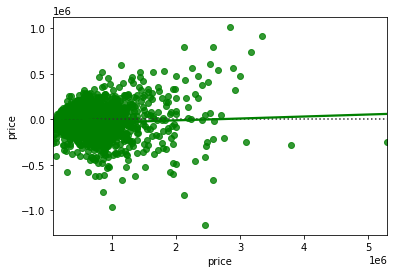

In [54]:
import seaborn as sns

sns.residplot(y_test, residuals, lowess=True, color="g")

## Step 8:  Refit your best model to the entire dataset.

In [55]:
df_train_selected = df_poly2[selected_columns]

lm_kBest.fit(df_train_selected, target)

y_pred_kBest = lm_kBest.predict(df_train_selected)

rmse_kBest = np.sqrt(metrics.mean_squared_error(target, y_pred_kBest))

print('Root Mean Squared Error: $', f"{round(rmse_kBest,2):,}")

Root Mean Squared Error: $ 128,353.31


## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [56]:
import pickle

pickle_out = open('pickled_files/model.pickle', 'wb')
pickle.dump(lm_kBest, pickle_out)
pickle_out.close()

In [57]:
pickle_out = open('pickled_files/selected_columns.pickle', 'wb')
pickle.dump(selected_columns, pickle_out)
pickle_out.close()

In [58]:
pickle_out = open('pickled_files/zips_by_price.pickle', 'wb')
pickle.dump(zips_by_price, pickle_out)
pickle_out.close()

In [59]:
features_to_poly2 = df_features.columns

pickle_out = open('pickled_files/features_to_poly2.pickle', 'wb')
pickle.dump(features_to_poly2, pickle_out)
pickle_out.close()